<a href="https://colab.research.google.com/github/SkyKT23/cs3120-assign2/blob/main/lab1_text_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSML4220 - Lab 1: Working with Text Data

In this notebook we'll explore the Airline Tweet dataset and implement the simplest _"model"_ that we can come up (we use quotes here to refer to _model_ because it likely doesn't look like what you would expect, given that it deals with text/language).  Ultimately, the model will predict whether a tweet is a) positive, b) neutral, or c) negative.

To run this notebook in Google Colab or on Kaggle, click one of the following links.  When you are done you will save your (completed) notebook in Kaggle, Colab, or a GitHub gist, and then submit the link to it in Canvas.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab1_text_data.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab1_text_data.ipynb)

Table of Contents
* [0: Python Review](#0-python-review)
* [1: Loading Data](#1-loading-dataset)
* [2: Develop Simple Model](#2-develop-simple-model)
* [3: Evaluate Simple Model](#3-evaluate-simple-model)
* [4: Tokenization via Stemming](#4-tokenization-via-stemming)
* [5: Tokenization via Lemmatization](#5-tokenization-via-lemmatization)
* [6: Vectorization (and a 'real' ML Model)](#6-vectorization)

All of the labs will have a few questions that you will need to answer (perhaps after modifying/writing some code). Ideally you work through this notebook from start to finish and answer the questions as you go. But to help ensure that no questions are left unanswered, they are linked to here:
* [Q1](#q1)
* [Q2](#q1)
* [Q3](#q3)
* [Q4](#q4)
* [Q5](#q5)
***
Note that this notebook does not look like most Jupyter notebooks you will see. That's because you will typically load all of the Python modules/libraries that you need at the beginning in the very first code cell. However, in order for us to see which library we're using where, we'll load them immediately before we need them. For a brief intro on what Jupyter notebooks are and how they work, check out [this short tutorial by Jeremy Howard](https://www.kaggle.com/code/jhoward/jupyter-notebook-101).
***

### 0: Python Review
Before we even get started though, let's quickly review a few important classes/datatypes that will come up often when working with Deep Learning models. The first of these is the [`pandas`](https://pandas.pydata.org/docs/index.html) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

To start, we'll import pandas and create a DataFrame object. But, first, let's create a simple Python [`dictionary`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries):

In [1]:
toy_dict = {'col_a':[1,2,3,4,5], 'col_b':['blue', 'red', 'red', 'purple', 'red']}
toy_dict

{'col_a': [1, 2, 3, 4, 5], 'col_b': ['blue', 'red', 'red', 'purple', 'red']}

Above we created a toy example of a pandas DataFrame. Most often a data frame will be created by reading an input file, but it's also possible to create one manually using a dictionary. We can verify the datatype is `dict` by using the `type()` function:

In [2]:
type(toy_dict)

dict

This dictionary can then be used to create a pandas data frame, where each `dict` key is a column name, and each corresponding `dict` value (which is a list) defines the data in that column.

In [3]:
import pandas as pd

toy_df = pd.DataFrame(toy_dict)
toy_df

,col_a,col_b
0,1,blue
1,2,red
2,3,red
3,4,purple
4,5,red


### 1: Loading Dataset
Now getting back to our problem... we want to use the Airline Tweets (text) dataset to create a simple model for predicting the tweet sentiment. To do so we'll need to load the dataset into a `pandas` `DataFrame`. If the data is stored locally then we would use `pd.read_csv("path/to/file/file.csv")` to open it. In this case, the data is online at GitHub. Fortunately, the `pandas` module also knows how to open a file from a URL without any additional parameters. So, we can still use the same method but with the URL instead of the local path, as seen below.

After loading the data file, we'll check what the dimensions of the data frame are (i.e. number of rows and number of columns - shown together in a single Python [`tuple`](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences)).

In [4]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/airlinetweets.csv'
df = pd.read_csv(data_URL)
df.shape

(10000, 2)

Now let's look at the first few observations (i.e. tweets) in the data frame using the DataFrame's `head` method. This is first and most basic step we can do in what is called, [Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis). We will not dig much into actual EDA in this notebook, but it's important to note that this is a critical step in any data analysis or modeling project. If we were to complete a full EDA though, there are many tools that can help out, such as the [ydata-profiling project](https://github.com/ydataai/ydata-profiling) Python module. Perhaps not surprising, AI tools and LLMs (e.g. ChatGPT) can even perform a simple EDA on a dataset.

 For now we will simply peek at the first few rows.


In [5]:
df.head(10)

,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I...
1,positive,@VirginAmerica thanks guys! Sweet route over t...
2,negative,@USAirways Your exchange/credit policies are w...
3,negative,@USAirways but in the meantime I'll be sleepin...
4,negative,@VirginAmerica hold times at call center are a...
5,negative,@USAirways not moving we are in the tarmac del...
6,neutral,@JetBlue What about if I booked it through Orb...
7,negative,@united 2nd flight also delayed no pilots! But...
8,negative,".@AmericanAir after 50 minutes on hold, and an..."
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


To be able to see the the full __text__ field/column we need to tell pandas to change its default column width to be displayed.

In [6]:
pd.set_option("display.max_colwidth", 240)
df.head()

,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much



We would typically also use the `describe` DataFrame method to see some descriptive statistics for each column, but as we'll see below. It does not provide as much for text data as for numerical data, but this is still useful information. Namely, how many non-empty cells are there in each column, how many unique values in each column, most frequently occuring value, and the frequency of the most frequenly occurring value in each column.

In [7]:
df.describe()

,sentiment,text
count,10000,10000
unique,3,9901
top,negative,@AmericanAir thanks
freq,6525,5


Now let's summarize the observations (i.e. tweets) by their labels (i.e. sentiment). We know there should be three possible values for the labels: positive, neutral, and negative. From above, we already know that _negative_ is the most frequent sentiment, but we can now see how many times the other sentiments (i.e. classes) appear.

In [8]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
negative,0.6525
neutral,0.1916
positive,0.1559


Let's now see what are the most common words used. Note that this means we need to separate the each tweet into the words. The most basic way to accomplish this is to use Python's string method, __split__. We can first confirm that the _text_ field is in a fact a string by looking at the data frame's data types with __dtypes__.

In [9]:
df.dtypes

,0
sentiment,object
text,object


Note that the _text_ column is not a string data type, but is instead the more general __object__ data type (note that everything in Python inherits from the __object__ data type). Because of Python's friendly dynamic behavior, we don't need to worry about this if we were to look at a single tweet. That is, Python will allow us to use the string.split() method when we are using a single tweet:


In [10]:
df.iloc[1,1].split()

['@VirginAmerica',
 'thanks',
 'guys!',
 'Sweet',
 'route',
 'over',
 'the',
 'Rockies',
 '#airplanemodewason']

However, if we try to use split on the entire column we'll run into an issue, as can be seen by the error we encountered here (if you uncomment the line in the following cell).

In [11]:
# df['text'].split()

To avoid this we need to use the [`str`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.html) attribute for the pandas [`DataSeries`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object. This will to allow for string methods to be used. We'll now do this for the first 5 rows of data.

In [12]:
df['text'][:5].str.split()

,text
0,"[@JetBlue, @JayVig, I, like, the, inflight, snacks!, I'm, flying, with, you, guys, on, 2/28!, #JVMChat]"
1,"[@VirginAmerica, thanks, guys!, Sweet, route, over, the, Rockies, #airplanemodewason]"
2,"[@USAirways, Your, exchange/credit, policies, are, worthless, and, shadier, than, the, White, House., Dissatisfied, to, the, nines, right, now.]"
3,"[@USAirways, but, in, the, meantime, I'll, be, sleeping, on, a, park, bench, on, dadeland, st., Thanks, guys!]"
4,"[@VirginAmerica, hold, times, at, call, center, are, a, bit, much]"


Let's now add a new column that contains the list of tokens (i.e. words) for each tweet. Note that the [`split()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html#pandas-series-str-split) method splits a string by the SPACE character by default. This looks alright for now, but we'll see how to improve this later on. Now, however, that we will also convert everything to lowercase before splitting.

In [13]:
df['tokens'] = df['text'].str.lower().str.split()
df.head()

,sentiment,text,tokens
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat,"[@jetblue, @jayvig, i, like, the, inflight, snacks!, i'm, flying, with, you, guys, on, 2/28!, #jvmchat]"
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason,"[@virginamerica, thanks, guys!, sweet, route, over, the, rockies, #airplanemodewason]"
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.,"[@usairways, your, exchange/credit, policies, are, worthless, and, shadier, than, the, white, house., dissatisfied, to, the, nines, right, now.]"
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!,"[@usairways, but, in, the, meantime, i'll, be, sleeping, on, a, park, bench, on, dadeland, st., thanks, guys!]"
4,negative,@VirginAmerica hold times at call center are a bit much,"[@virginamerica, hold, times, at, call, center, are, a, bit, much]"


### 2: Develop Simple Model

Let's now get into our naive model approach we discussed earlier. The idea was to count how often each word (i.e. token) appears in all of the positive tweets, in all of the negative tweets, and in all of the neutral tweets. Before that though, let's simply count how often each word occurs across all of the tweets. We'll use a `dict` datatype for this,  each __key__ is a word and the key's __value__ will be the number of times that word appears.

In [14]:
vocab = dict()
for tweet_tokens in df['tokens']:
    for token in tweet_tokens:
        if token not in vocab:
            vocab[token] = 1
        else:
            vocab[token] += 1

len(vocab)

20975

Let's sort these by the frequency with which each word (i.e. token) appears and then look at the top 20 or so.

In [15]:
vocab_sorted = dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))
list(vocab_sorted.items())[:25]

[('to', 5881),
 ('the', 4117),
 ('i', 3625),
 ('a', 3149),
 ('for', 2770),
 ('on', 2596),
 ('and', 2587),
 ('@united', 2569),
 ('you', 2510),
 ('my', 2282),
 ('flight', 2243),
 ('@usairways', 2061),
 ('@americanair', 1989),
 ('is', 1921),
 ('in', 1707),
 ('@southwestair', 1619),
 ('of', 1490),
 ('@jetblue', 1352),
 ('your', 1208),
 ('have', 1138),
 ('was', 1100),
 ('with', 1055),
 ('me', 1053),
 ('it', 1051),
 ('not', 1047)]

Not surprising that words such as, "_to_", "_the_", "_i_", etc. are the most frequently appearing. It seems that most of these will also not convey much information in terms of sentiment. To prevent such uninformative words from influencing the task at hand, most NLP libraries/tasks provide an easy way to remove stop words.

Before utilizing to a Python module designed to work with text data, let's first try continuing with our simple manual approach. Let's see if we can see some difference between in the word (i.e. token) frequencies when we separate the data frame into positive, neutral, and negative.

In [16]:
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for tweet_tokens in tokens_column:
        for token in tweet_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))

Let's now output the most frequently occuring words for each sentiment class.

In [17]:
list(vocab_pos.items())[:15]

[('the', 646),
 ('to', 601),
 ('for', 460),
 ('you', 421),
 ('i', 383),
 ('@southwestair', 381),
 ('a', 350),
 ('@jetblue', 340),
 ('@united', 330),
 ('thank', 320),
 ('and', 284),
 ('thanks', 263),
 ('my', 245),
 ('@americanair', 229),
 ('in', 216)]

In [18]:
list(vocab_neg.items())[:15]

[('to', 4237),
 ('the', 2898),
 ('i', 2519),
 ('a', 2296),
 ('and', 2049),
 ('on', 1966),
 ('for', 1930),
 ('@united', 1828),
 ('my', 1699),
 ('flight', 1697),
 ('you', 1694),
 ('@usairways', 1671),
 ('is', 1483),
 ('@americanair', 1467),
 ('in', 1219)]

In [19]:
list(vocab_neu.items())[:15]

[('to', 1043),
 ('i', 723),
 ('the', 573),
 ('a', 503),
 ('on', 415),
 ('@southwestair', 414),
 ('@united', 411),
 ('you', 395),
 ('for', 380),
 ('@jetblue', 365),
 ('my', 338),
 ('flight', 337),
 ('@americanair', 293),
 ('is', 291),
 ('can', 278)]

The output above confirms that many of the overall most frequently occuring words are not correlated in anyway with the sentiment of the tweet since, for example, "_to_", is the first or second frequently occurring for each separate group. In other words, there still a lot of stop words in the vocabularies for positive, negative and neutral tweets. Let's try removing the tokens from each of these vocabularies, if the token is also in the top, say, $100$, tokens overall.
<a id="topn2remove"></a>

In [104]:
top_n_to_remove = 100
for item in list(vocab_sorted.items())[:top_n_to_remove]:
    #print(f" removing token: {item[0]:15} (w/ freq = {item[1]:5}) from vocabs")
    if item[0] in vocab_pos:
        del vocab_pos[item[0]]
    if item[0] in vocab_neg:
        del vocab_neg[item[0]]
    if item[0] in vocab_neu:
        del vocab_neu[item[0]]


In [105]:
list(vocab_pos.items())[:15]

[(':-)', 16),
 ('kudos', 13),
 ('great!', 13),
 ('rock!', 13),
 ('awesome!', 13),
 ('wonderful', 12),
 ('excited', 11),
 ('you!!', 11),
 ('much.', 10),
 ('keeping', 10),
 ('much!', 10),
 ('passbook', 10),
 ('favorite', 9),
 ('@fortunemagazine', 9),
 ('you!!!', 9)]

In [106]:
list(vocab_neg.items())[:15]

[("weren't", 17),
 ('min.', 17),
 ('suck', 16),
 ('cut', 16),
 ('switched', 16),
 ('screw', 16),
 ('worst.', 16),
 ('fucking', 16),
 ('hours,', 16),
 ('ruined', 16),
 ('load', 16),
 ('lines', 16),
 ('failed', 15),
 ('90', 15),
 ('refuse', 15)]

In [107]:
list(vocab_neu.items())[:15]

[('street', 13),
 ('#avgeek', 12),
 ('journal', 11),
 ('hi,', 11),
 ('battles', 10),
 ('appease', 10),
 ('daily', 10),
 ('nashville', 9),
 ('feb', 9),
 ('routes', 9),
 ('departing', 9),
 ('waterbury', 8),
 ('republican', 8),
 ('march', 8),
 ('hi!', 8)]

That looks a little better! Now, let's try classifying the tweets by looking at one and counting how many tokens it has from the top k tokens in the vocab_pos, vocab_neg, and vocab_neutral sets. Whichever vocab it has the greatest number of tokens from, let's classify it as that.

To accomplish this let's first create a vocabulary for each of the possible label values. Note that below we are including all the tokens for each label but we could easily include just the top k positive tokens, top k negative, etc.

In [108]:
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}

Let's count exactly how many tokens will be considered for each class. It's not surprising that there are the most negative tokens. That's because most of the tweets are negative, so there are more unique tokens among the negative tweets.

In [109]:
print(f"positive tokens: {len(classifier_tokens['positive'])} \
      \nnegative tokens: {len(classifier_tokens['negative'])} \
      \nneutral tokens: {len(classifier_tokens['neutral'])}")

positive tokens: 4198       
negative tokens: 14338       
neutral tokens: 5482


Let's see what the classifier_tokens dictionary looks like


In [110]:
# let's see the top 20 tokens for each sentiment
for sentiment in classifier_tokens:
    print(f"top 10 tokens for {sentiment} tweets: \n    {classifier_tokens[sentiment][:20]}")

top 10 tokens for positive tweets: 
    [':-)', 'kudos', 'great!', 'rock!', 'awesome!', 'wonderful', 'excited', 'you!!', 'much.', 'keeping', 'much!', 'passbook', 'favorite', '@fortunemagazine', 'you!!!', '👍', 'home!', 'today!', 'prompt', 'amazing.']
top 10 tokens for negative tweets: 
    ["weren't", 'min.', 'suck', 'cut', 'switched', 'screw', 'worst.', 'fucking', 'hours,', 'ruined', 'load', 'lines', 'failed', '90', 'refuse', 'screwed', 'fail', 'plane,', 'why?', 'total']
top 10 tokens for neutral tweets: 
    ['street', '#avgeek', 'journal', 'hi,', 'battles', 'appease', 'daily', 'nashville', 'feb', 'routes', 'departing', 'waterbury', 'republican', 'march', 'hi!', 'tomorrow?', 'fl', '#flyingitforward', 'domestic', 'deals']


Okay, we're almost done. Let's now define the so-called model by implementing a `predict` function. There are many variations of this that could be done, but this is what we have.

In [112]:
def predict_tweet_sentiment(tweet_tokens, verbose=False):
    if verbose:
        print(f"tweet: {' '.join(tweet_tokens)}")
    pos = 0
    neg = 0
    neu = 0
    for tok in tweet_tokens:
        if tok in classifier_tokens['positive']:
            pos += 1
        elif tok in classifier_tokens['negative']:
            neg += 1
        elif tok in classifier_tokens['neutral']:
            neu += 1
    if verbose:
        print(f"counts: \n  postive tokens: {pos}\n  negative tokens: {neg}\n  neutral tokens: {neu}")
    if pos > neg and pos > neu:
        prediction = "positive"
    elif neu > pos and neu > neg:
        prediction = "neutral"
    else:
        prediction = "negative"
    if verbose:
        print(f"prediction: {prediction}")
    return prediction

Let's see what happens when we try to classify one single tweet using our `predict` function.

In [113]:
i = 100
print(df.iloc[i,:])
tweet2classify = df.iloc[i,:]['tokens']

sentiment                                                                                                                                                                          negative
text                                             @AmericanAir thx for responding. I cant watch 2 mins of this film w/out it cutting in and out 4 prolonged prds of time. beyond frustrating
tokens                 [@americanair, thx, for, responding., i, cant, watch, 2, mins, of, this, film, w/out, it, cutting, in, and, out, 4, prolonged, prds, of, time., beyond, frustrating]
predicted_sentiment                                                                                                                                                                negative
Name: 100, dtype: object


In [114]:
predict_tweet_sentiment(tweet2classify, verbose=True)

tweet: @americanair thx for responding. i cant watch 2 mins of this film w/out it cutting in and out 4 prolonged prds of time. beyond frustrating
counts: 
  postive tokens: 0
  negative tokens: 6
  neutral tokens: 0
prediction: negative


'negative'

### 3: Evaluate Simple Model

Let's now make predictions for all of the tweets in the dataset.

In [115]:
df['predicted_sentiment'] = df['tokens'].apply(lambda x: predict_tweet_sentiment(x))

Let's look at a few of the predictions as compared to the actual (i.e. true) labels.

In [116]:
df[['sentiment','predicted_sentiment','text']].head(10)

,sentiment,predicted_sentiment,text
0,positive,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,positive,@VirginAmerica hold times at call center are a bit much
5,negative,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,positive,@JetBlue flight 117. proud to fly Jet Blue!


model accuracy: 81.83%


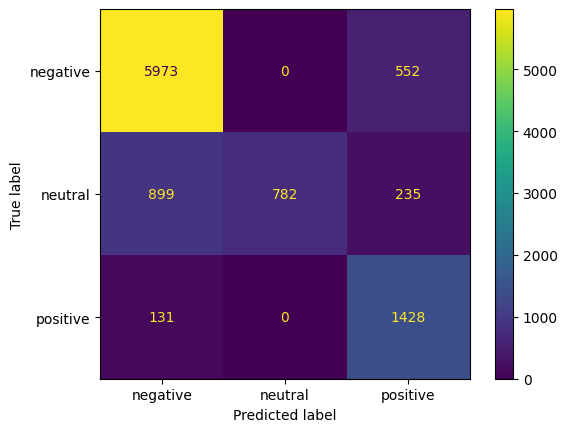

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
confusion_matrix(df['sentiment'], df['predicted_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], df['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()

mod_accuracy = accuracy_score(df['sentiment'], df['predicted_sentiment'])
print(f"model accuracy: {mod_accuracy*100:.2f}%")

***
#### Q1
Go back to where we declared `top_n_to_remove` ([here](#topn2remove)). Try changing the value to see if you can improve the accuracy of our model. No need to justify or explain the value you use, just try experimenting with considerably smaller or larger values and see if you can improve the accuracy.

What is the model accuracy that you get? Were you able to beat ~66% (the accuracy if every tweet were predicted to be negative)?

`<input your answer here>`

Declaring with top_n_to_remove = 1000 vs. 100 increased the accuracy to 81.83%, which is dramatically more than the ~30% accuracy of top_n_to_remove = 100, with all the false positive reports.

***

#### Q2
Does the model accuracy we found above give you a good idea of how this model will perform on future tweets? If not, then what could you do to get a better idea of how it will perform on future tweets?

`<input your answer here>`

I don't think it will give us a good idea of how it will perform on future tweets based on this alone. It seems to be heavily biased towards identifying negative tweets because of the tokens identified that signify "negative" tweets. Several of the selected tokens could very well appear in positive tweets. Trying to refine how the words are identified in negative tweets could help this.

***

### 4: Tokenization via Stemming

Our tokenization approach above was very basic. All we did was split the text on spaces. This resulted in there being separate tokens for strings like "_delay_" and "_delayed_". Let's now try using a better approach to tokenization known as [__stemming__](https://en.wikipedia.org/wiki/Stemming).

Recall that stemming is an approach in which words are truncated to attempt to find the same root or base word. We'll use the natural language toolkit ([__nltk__](https://www.nltk.org/index.html)) for this and try it on an example below.

In [ ]:
from nltk.stem import LancasterStemmer
words = ["delay", "delayed", "delays"]
#words = ["run", "running", "runs", "ran"]
#words = ["fly", "flying", "flies", "flew"]
stemmer = LancasterStemmer()
for word in words:
    print(f"{word} -> {stemmer.stem(word)}")

Even though stemming is very simple, it is quick and often gives the desired results (although try it with the other set of words above and see what you get).

Before applying the stemming step, we also want to take care of the extra characters or symbols, such as periods, exclamation marks, while keeping the "@" and "#" symbols in place (since these are often used in tweets). Fortunately, nltk also has a Twitter-specific method to remove these symbols, called the __TweetTokenizer__.  We'll also load the data again to ensure we are starting from the beginning, and remove stopwords.

In [ ]:
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
df.head(5)

In [ ]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))

In [ ]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?', ','])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

As you can see above, that first step of tokenization is helpful, but did not include stemmming (as you can tell from words such as "_fly_ ___ing___", "_thank_ ___s___", and "_sleep_ ___ing___".  So let's apply the stemming now and see what the results look like.

In [ ]:
df['tokens'] = df['tokens_raw'].apply(lambda x: [stemmer.stem(w) for w in x])
df.head()

Next, let's remove common stop words (e.g. "_the_", "_in_", etc.). In this next cell we will also remove some characters/punctuation, as well as hashtag tokens.

Let's now recreate the same simple model that we used earlier, but now with the cleaned up tokens.

In [ ]:
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for tweet_tokens in tokens_column:
        for token in tweet_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))

In [ ]:
list(vocab_pos.items())[:10]


In [ ]:
list(vocab_neg.items())[:10]

In [ ]:
list(vocab_neu.items())[:10]

In [ ]:
classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}
print(f"positive tokens: {len(classifier_tokens['positive'])} \
      \nnegative tokens: {len(classifier_tokens['negative'])} \
      \nneutral tokens: {len(classifier_tokens['neutral'])}")

***
#### Q3
In [Q2](#q2) you were asked about the model accuracy we found earlier, and whether we could expect it to be representative of the accuracy we'd see on future, unseen, tweets. Hopefully you realized that without a proper train-test split, we won't have a good idea. Would right now (after we've created the classifier_tokens), be a good time to create a train-test split? Why or why not?

`<input your answer here>`
***

In [ ]:
i = 100
print(df.iloc[i,:])
tweet2classify = df.iloc[i,:]['tokens']
predict_tweet_sentiment(tweet2classify, verbose=True)

Suprisingly, the tweet above was misclassified this time, but it was correctly classified back before we even used stemming. Let's see now how it performs on all $10k$ tweets though.

In [ ]:
df['predicted_sentiment'] = df['tokens'].apply(lambda x: predict_tweet_sentiment(x))
df[['sentiment','predicted_sentiment','text', 'tokens']].head(10)

Let's see if that misclassification was just a fluke, and whether this model with stemming has higher accuracy than the earlier model.

In [ ]:
confusion_matrix(df['sentiment'], df['predicted_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], df['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
mod_accuracy = accuracy_score(df['sentiment'], df['predicted_sentiment'])
print(f"model accuracy: {mod_accuracy*100:.2f}%")

These results are actually considerably worse than what we saw before. It's not because of the stemming though, it's because even after removing stop words, there are still many words that frequently appear regardless of the sentiment. In the first, simple approach, we removed frequently occurring words like these, but this time we didn't. If we did, then tokens such as "__flight__", or "__hav__", would also be removed, and we'd see much higher accuracy.

### 5: Tokenization via Lemmatization

Let's now try using Lemmatization. We'll again start with a clean version of the data and use the TweetTokenizer.

In [ ]:
df = pd.read_csv(data_URL)
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))
print(f"df.shape: {df.shape}")
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links
df.head()


Since Lemmatization can convert words such as "_ran_" into "_run_", it requires knowledge of the English language. Because of that, you may or may not need to first download a dictionary of sorts. To do this, uncomment the following code cell and run it.

In [ ]:
 #import nltk
 #nltk.download('wordnet')
 #nltk.download('omw-1.4')

If the dictionary is available, then the following code will run correctly. If the following cell encounters an error, then uncomment the above cell and run it.

Assuming the dictionary is available, then let's go ahead and carry out the Lemmatization. Note that there are much better ways to do this but that we want to use a simple lemmatizer. For example, some lemmatizers also utilize a model internally to predict the part-of-speech for each word, since whether the word is a noun, adjective, verb, etc. will affect how lemmatization is done. Since we want to keep things simple here, and focus only on the lemmatization step, we'll assume every word is the same part of speech. Note that this is not by any means ideal (try to identify the incorrectly lemmatized token in the five tweets printed out below). In practice we would utilize a 'smarter' lemmatizer .

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df.head()

Let's now recreate the same simple model that we used earlier, but now with the cleaned up tokens.

In [ ]:
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neu = df[df['sentiment'] == 'neutral']

def create_vocab_list(tokens_column):
    vocab = dict()
    for tweet_tokens in tokens_column:
        for token in tweet_tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    return vocab

vocab_pos = dict(sorted(create_vocab_list(df_pos['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neg = dict(sorted(create_vocab_list(df_neg['tokens']).items(), key=lambda item: item[1], reverse=True))
vocab_neu = dict(sorted(create_vocab_list(df_neu['tokens']).items(), key=lambda item: item[1], reverse=True))

classifier_tokens = {"positive": list(vocab_pos.keys())[:], "negative": list(vocab_neg.keys())[:], "neutral": list(vocab_neu.keys())[:]}
print(f"positive tokens: {len(classifier_tokens['positive'])} \
      \nnegative tokens: {len(classifier_tokens['negative'])} \
      \nneutral tokens: {len(classifier_tokens['neutral'])}")

And let's try making a prediction for a specific tweet.

In [ ]:
i = 100
print(df.iloc[i,:])
tweet2classify = df.iloc[i,:]['tokens']
predict_tweet_sentiment(tweet2classify, verbose=True)

Again, it is misclassified, but let's see whether the Lemmatization at performs better than the Stemming.

In [ ]:
df['predicted_sentiment'] = df['tokens'].apply(lambda x: predict_tweet_sentiment(x))
df[['sentiment','predicted_sentiment','text', 'tokens']].head(10)

In [ ]:
confusion_matrix(df['sentiment'], df['predicted_sentiment'])
disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], df['predicted_sentiment']), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
mod_accuracy = accuracy_score(df['sentiment'], df['predicted_sentiment'])
print(f"model accuracy: {mod_accuracy*100:.2f}%")

***
#### Q4
Even with the Stemming/Lemmatization, is it possible to use a proper machine learning model? For example, could we use linear regression, or even random forest? Why or why not? Explain by stating what the input to the model would be (or would need to be).

`<input your answer here>`
***

### 6: Vectorization

To convert the tokens to numerical data we'll now use a form of vectorization. Let's first remove the previous predictions and then create a new column with the tokens joined together. We need to do this because the vectorization method works on the full text of each observation (not the list of tokens that we have been using up until now).

In [ ]:
if 'predicted_sentiment' in df.columns:
    print("removing column, predicted_sentiment, from df")
    df.drop('predicted_sentiment', axis=1, inplace=True)

df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

Let's also use a proper train-test split in order to get a better idea of how the model will perform on unseen data (we can still compare the training split to the results above to see how this approach works). We could use sklearn's train_test_split() function for this, but we'll do it manually here as a quick review.

In [ ]:
import random
random.seed(42)

df_full = df.copy()
assert df_full.shape[0] == 10000

indices = list(range(df_full.shape[0]))

random.shuffle(indices)

train_indices = indices[:8500]
test_indices = indices[8500:]

# df will be the in-sample training dataset
df = df_full.iloc[train_indices,:].copy()
print(f"df.shape: {df.shape}")

# df_test will be the out-of-sample validation dataset
df_test = df_full.iloc[test_indices,:].copy()
print(f"df_test.shape: {df_test.shape}")
df_test.head()

Now we will load the term-frequency inverse-document-frequency vectorizer from sklearn, `TfidfVectorizer`, to convert each tweet into a vector. We'll go ahead and call the resulting vectorized data, `X`, or `X_train` since it is only the training dataset. As with conventional statistical models, "_X_" represents the set of predictors, or independent variables.

Also, note that `TfidfVectorizer` is a powerful text processing object. It has the ability to remove stop words, strip symbols, and do much of the work that our manual tokenization did. As such, we could easily use the original tweet text here, but we'll go ahead and continue with our manually tokenized data in the column, `textclean`.
<a id="changetraining"></a>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(df['textclean']).toarray()
#X_train = tfidf_vectorizer.fit_transform(df['text']).toarray() # original tweet text (without our manual tokenization)

print(f"X_train.shape = {X_train.shape}")
type(X_train)

Note that the data type for `X_train` is no longer a pandas data frame. Instead, it is a numpy ndarray. We will talk much more about the python module, numpy, and its data types in the coming week. For now, let's just think of it a more efficently implemented object than a pandas data frame (e.g. smaller memory footprint), and one that we can think of a more of a matrix than a table of data. This can be seen by how we can easily index into `X_train` without the need for methods such as `iloc` or `loc`. Here we will look at the first 5 rows and 10 columns.

In [ ]:
X_train[:5, :10]

Looking at the output above, and back at the dimensions of `X_train` two cells back, what does this tell you about the data (aside from the size of the training data)? Specifically, what do the number of columns represent?

If you're not sure, then look at the output of the following cell. We are looking at the first row of the training dataset, `X_train` again, but looking only at the non-zero values. These are the term-frequency inverse-document-frequency values for this tweet.

In [ ]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 token at column i={i}, has a non-zero TF-IDF value: {tfidf_val}")

If we wanted to, we could retrieve the token associated with each column of `X_train` by using the `tfidf_vectorizer`. Let's do that now just to see if we can try to recover the tweet. You'll notice that we can't recover the ordering of the words, but rather just the set of words that were in the tweet.

In [ ]:
obs1 = list(X_train[0,:])
for i, tfidf_val in enumerate(obs1):
    if tfidf_val > 0:
        print(f"obs1 has a non-zero TF-IDF value: {tfidf_val} at col i={i} (associated with token: {tfidf_vectorizer.get_feature_names_out()[i]})")

We can verify this by going back to our training dataset, `df`, and checking what the first observation was. Looking at the output below. As stated above, we see that the same words are present in the data but not necessarily in the same order. Disregarding word order when vectorizing text data is sometimes (informally) referred to as a "[__bag-of-words__](https://en.wikipedia.org/wiki/Bag-of-words_model)" approach. Often times, "__bag-of-words__" suggests that just the counts (i.e. __term frequency__) is used, rather than what we are using here, __term-frequency inverse-document-frequency__. Nonetheless, the underlying idea that words frequency is accounted for, but word order is neglected, is an important observation to make here.

In [ ]:
df.iloc[0,:]

A good default model to start with that does not require too much fine tuning, and generally performs well is a [__Random Forest__](https://en.wikipedia.org/wiki/Random_forest) model. We won't dig into the details of how an RF model works exactly, but so long as we know that it creates many decision trees on random subsets of the data, then you've got a decent idea. Before doing so, we also need to convert the labels (i.e. `df.sentiment`) to a numpy data type. We'll quickly do that now and look at the first few observations.

In [ ]:
y_train = df.sentiment.to_numpy()
y_train[:10]

We'll not fit the random forest model on the training data and check the performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_train

disp = ConfusionMatrixDisplay(confusion_matrix(df['sentiment'], predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(df['sentiment'], predictions_train):.4f}")

Wow! Accuracy of ~99% is much better than what we saw with our ad hoc model. Let's check and see how well the model does on the test dataset now.

Notice that we are using `tfidf_vectorizer.transform()` now, and not the same method we used before on the training dataset, which was `tfidf_vectorizer.fit_transform()`. The `fit_transform` method creates the vocabulary from the training data. The `transform` method will use the vocabulary that was previously made, but if it encounters a token in the test data that was never seen in the training data, then it will simply ignore it. This is one reason why making sure that training data for models is regularly updated.
<a id="changetest"></a>

In [ ]:
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))
X_test = tfidf_vectorizer.transform(df_test['textclean']).toarray()
#X_test = tfidf_vectorizer.transform(df_test['text']).toarray() # use original tweet text (without our tokenization)
X_test.shape

In [ ]:
predictions_test = model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(df_test['sentiment'], predictions_test), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_test): {accuracy_score(df_test['sentiment'], predictions_test):.4f}")

Okay, the model performance on the test data is not nearly as good as the performance on the training dataset. That's expected to some degree.

We may be able to improve it slightly by finding the optimal value of one of the random forest hyperparameters, e.g. `n_estimators`. However, one of the strengths of random forest is not it does a good job of overfitting. Knowing that, how do you think smaller values of `n_estimators` will affect accuracy on the test data? How do you think larger values will affect it? Try a few different values of `n_estimators`, both larger and smaller than the default of `n_estimators=100`, to see what happens.

Below we go ahead and try many different hyperparameter values (for n_estimators) to see what the best value is. As can be seen, there is not an immediately obvious choice for the best value of the n_estimators hyperparameter, which is exactly why random forest is such a nice to model to use at the beginning. Admittedly, an RF model might not perform as well as some other machine learning models, but it is reliable and does a decent job at balancing the Bias-Variance Tradeoff right away without a lot of tuning.

In [ ]:
from sklearn.metrics import log_loss

# A function to create and fit a RF with a specific number of trees
def fitRFModel(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_test)
    y_val_pred = rf_model.predict(X_test)
    train_loss = log_loss(df['sentiment'], y_train_pred_prob, labels=['negative', 'neutral', 'positive'])
    train_acc = accuracy_score(df['sentiment'], y_train_pred)
    val_loss = log_loss(df_test['sentiment'], y_val_pred_prob, labels=['negative', 'neutral', 'positive'])
    val_acc = accuracy_score(df_test['sentiment'], y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

hyp_param_vals = list(range(5, 206, 50)) # possible values for n_estimators
metrics = []
for hp in hyp_param_vals:
    metrics.append(fitRFModel(hp))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # test loss
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax.legend(["Test Loss", "Train Loss"], loc=1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="loss (lower is better)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_axes([0, 0, 1, 1]) #.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # test accuracy
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax.legend(["Test Accuracy", "Train Accuracy"], loc=4)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
plt.show()

***
#### Q5
What happens if we don't use the the `textclean` column (which was based on the lemmatized tokens and stopword removal), but instead use the original `text` column? Remember that you need to change this not just for the [training data](#changetraining), but also for the [test data](#changetest). Then, we want to know specifically...

Q5a: How many more (or fewer) input features are there when using TFIDF on the original (un-lemmatized) `text` column?

`<input your answer here>`

Q5b: Is the accuracy better or worse when using the original `text` column?

`<input your answer here>`
***